# Introduction

Lab 3 focuses on feature extraction methods and clustering algorithms. Part 1 addresses the clustering of interesting features from the "faces in the wild" dataset. This dataset contains images of celebrities along with an accompanying label. The second part of the lab focuses on measuring the impact of preprocessing methods or combinations of preprocessing methods to improve the results of algorithms that have been studied in previous labs. The datasets for part two are "faces in the wild", MNIST (a dataset containing labeled pictures of handwritten digits), and energy which countains five features and an associated value.

# Algorithms Used

## K-Means

K-Means functions by taking as an input a specified number of clusters to build. The algorithm starts by assigning these points (equal to the number of clusters) at random. The algorithm then assigns each sample to the closest cluster center point. Once each point is assigned a cluster, the mean of each cluster is taken and the center point is reassigned to that point. The algorithm repeates by reassigning samples to the new points. This process naturally converges to a point where the change of each new central point is minimal.

One of the most challenging parts of using this algorithm is determining how many clusters to use. In a case where labels are proviced, this is typically equal to the number of unique class labels. If there aren't class labels then the data must be analyzed to identify properties of each cluster.

## DBSCAN

DBSCAN has two very important hyperparameters, a neighborhood distance value, and a minimum support number. The algorithms conducts a DFS from each point to determin if there are "x >= min_sup" number of points within the set neighborhood distance. A point that meets this criterion is called a "core point". Points within the radius of a core point that do not satisfy "min_sup" are called border points. Border points are considered to be part of the same cluster as their related core points. Additionally, points that don't meet any of theses criteria are labelled as "noise".

## Agglomerative Clustering

This method of clustering is similar to DBSCAN in that it starts with individual points being considered as clusters. The algorithm begins by considering every point as a cluster and attempts to combine them in a way that minimizes some value, referred to as linkage. The most common linkage method in scikit learn are ward, complete, and average. Ward links the two clusters that increase the variance the least. Average joins clusters that have the shortest mean distance between one another. Complete considers all points in the cluster and joins clusters based on points with maximum distance. This algorithm continues to merge clusters until it reaches a stopping criteria. In most cases this is a set number of desired clusters.

## Normalization and Standardization

Normalization and standardization make modifications to features so that they scale in a more acceptable way when compared with one another. Normalization typically transforms data by subtracting the minimum and dividing by the delta of the maximum and minimum sample values. This ensures that the data will be within the range of 0 to 1, with the maximum value in the set being a 1 and the minimum a 0. Standardization works by subtracting the mean and dividing by the standard deviation. This fits the data to a distribution centered at 0. Typically, algorithms that compare features using the same heuristics are heavily influenced by these two transformations.

## Principal Component Analysis (PCA)

PCA is a method of reducing dimensionality of data by taking the direction of maximum variance and reassigning it as the primary feature. Each additional feature is an orthogonal direction (with respect to last feature) that contains the highest variance. This enables for the reduction of feature dimension without deforming the data in an irrecoverable way. Isolating directions with maximum variance ensures that the algorithms that use the data will have a large amount of information to work with, despite having a lower number of features under consideration.

## Non-negative Matrix Factorization (NMF)

This process requires all values to be non-negative because it works by finding matrix factorizations that model points in the data set. Just like PCA, NMF attempts to reduce the number of features but keep aspects that enable agorithms to make informed predictions.

# Experimental Results

In [2]:
from sklearn.cluster import AgglomerativeClustering, DBSCAN, KMeans
from sklearn.datasets import fetch_lfw_people
from sklearn.decomposition import NMF, PCA
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, mean_squared_error
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import Normalizer, StandardScaler, normalize, scale
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#### Declarations

Declarations of common variables and dictionaries.

In [3]:
RESOURCES = "../res/"
DEFAULT_SEED = 99

X = {}
X_pca = {}
y = {}
X_train = {}
X_test = {}
y_train = {}
y_test = {}

clusters = {}

#### Loading the data

The data is loaded into a dictionary for easy reference. X is constructed for use by clustering algorithms.

In [4]:
energy_data = pd.read_csv(filepath_or_buffer=RESOURCES+"energy.txt", 
                          names=['x1', 'x2', 'x3', 'x4', 'x5', 'y'])

mnist_data = pd.read_csv(filepath_or_buffer=RESOURCES+"mnist.txt", 
                         header=None)

lfw_people = fetch_lfw_people(data_home=RESOURCES, min_faces_per_person=10, resize=0.7)

names = lfw_people.target_names.tolist()

X_train['energy'], X_test['energy'], y_train['energy'], y_test['energy'] = train_test_split(
    energy_data[['x1', 'x2', 'x3', 'x4', 'x5']], energy_data[['y']],
    test_size=0.2, train_size=0.8, random_state=99, shuffle=True
)

X_train['mnist'], X_test['mnist'], y_train['mnist'], y_test['mnist'] = train_test_split(
    mnist_data.iloc[:,:784], mnist_data.iloc[:,784],
    test_size=0.2, train_size=0.8, random_state=99, shuffle=True
)

X_train['faces'], X_test['faces'], y_train['faces'], y_test['faces'] = train_test_split(
    lfw_people.data, lfw_people.target, test_size=0.2, train_size=0.8, random_state=99, 
    shuffle=True
)

for key in X_train:
    X[key] = np.concatenate((X_train[key], X_test[key]), axis=0)
    y[key] = np.concatenate((y_train[key], y_test[key]), axis=0)

In [5]:
# code from "Introduction to Machine Learning with Python" pg. 149

mask = np.zeros(y['faces'].shape, dtype=np.bool)
for target in np.unique(y['faces']):
    mask[np.where(y['faces'] == target)[0][:50]] = 1

X['faces'] = X['faces'][mask]
y['faces'] = y['faces'][mask]

# scale the grayscale values to be between 0 and 1
# instead of 0 and 255 for better numeric stability
X['faces'] = X['faces'] / 255

# Clustering

## K-Means

### MNIST

MNIST was an interesting dataset to analyze with clustering algoirthms. PCA was used to extract two features that were then clustered using KMeans. KMeans attempts to build 10 clusters because there are 10 possible digits in the class. The colors in the figure highlight the cluster, whereas the numbers indicate the ground truth. KMeans does an excellent job of clustering 1s and 0s given their distinct form. There is significant overlap with the other digits. In this example, 8s and 3s are commonly clustered and 9s, 4s, and 7s are typically grouped.

In [418]:
pca = PCA(n_components=2)
X_pca['mnist'] = pca.fit_transform(X['mnist'])

kmeans = KMeans(n_clusters=10, random_state=DEFAULT_SEED)

kmeans.fit(X_pca['mnist'])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=99, tol=0.0001, verbose=0)

Text(0,0.5,'Second principal component')

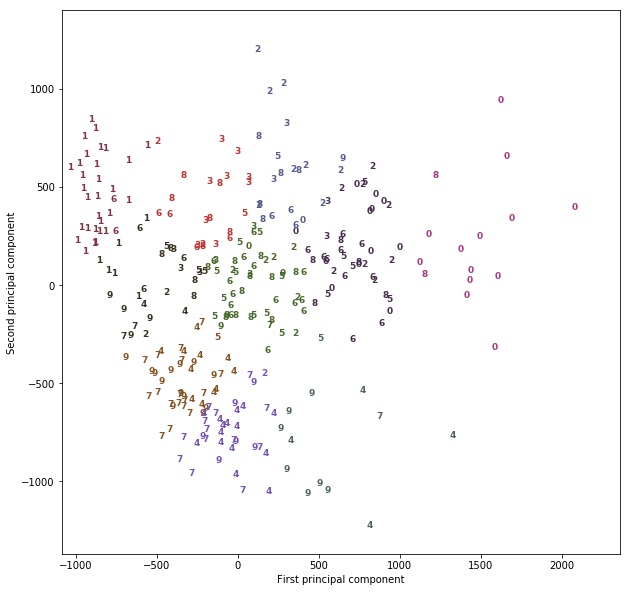

In [419]:
# parts of code from "Introduction to Machine Learning with Python" pg.165

N_SAMPLES = 300

colors = ["#476A2A", "#7851B8", "#BD3430", "#4A2D4E", "#875525",
          "#A83683", "#4E655E", "#853541", "#3A3120", "#535D8E"]

plt.figure(figsize=(10, 10))
plt.xlim(X_pca['mnist'][:, 0].min(), X_pca['mnist'][:, 0].max())
plt.ylim(X_pca['mnist'][:, 1].min(), X_pca['mnist'][:, 1].max())

for i in range(N_SAMPLES):
    plt.text(X_pca['mnist'][i, 0], X_pca['mnist'][i, 1], str(y['mnist'][i]),
             color = colors[kmeans.labels_[i]],
             fontdict={'weight': 'bold', 'size': 9})

plt.xlabel("First principal component")
plt.ylabel("Second principal component")

### Faces in the Wild

In [502]:
pca = PCA(n_components=50)
X_pca['faces'] = normalize(pca.fit_transform(X['faces']))

#### Bush vs Putin

George W Bush and Vladimir Putin were compared using KMeans. As you can see below, the algorithm successfully makes two clusters. Unfortunately, the ground truth indicates that KMeans failes to distinguish pictures of Putin and Bush. Upon inspection of the images, both appear to have similar lighing. Additionally, both individuals have the same complexion and attire so I would imagine this is the source of the poor performance.

In [465]:
X_putin = X['faces'][y['faces'] == names.index("Vladimir Putin")]
y_putin = y['faces'][y['faces'] == names.index("Vladimir Putin")]

X_bush = X['faces'][y['faces'] == names.index("George W Bush")]
y_bush = y['faces'][y['faces'] == names.index("George W Bush")]

print("Samples:")
print("Bush ", len(y_bush))
print("Putin ", len(y_putin))

Samples:
Bush  50
Putin  49


In [466]:
X_putin_vs_bush = np.concatenate((X_putin, X_bush), axis=0)
y_putin_vs_bush = np.concatenate((y_putin, y_bush), axis=0)

# pca = PCA(n_components=50)
X_putin_vs_bush_pca = pca.fit_transform(X_putin_vs_bush)

Text(0.5,1,'Bush vs Putin')

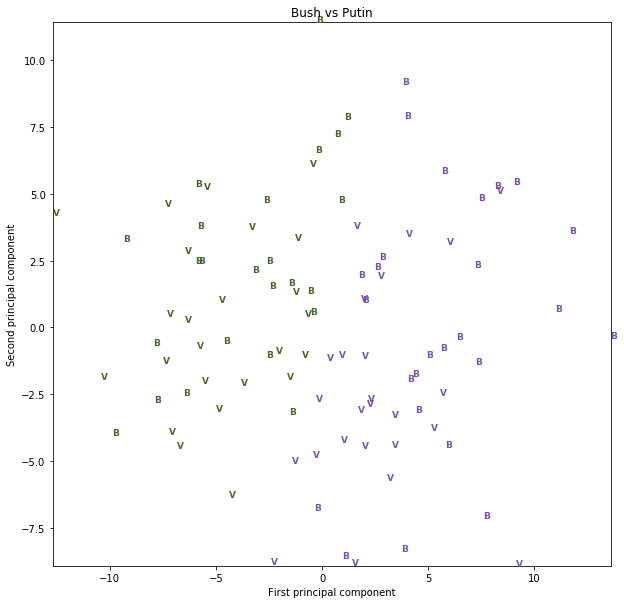

In [467]:
kmeans = KMeans(n_clusters=2, random_state=DEFAULT_SEED)

kmeans.fit(X_putin_vs_bush_pca)

clusters['kmeans_pvb'] = kmeans.labels_

colors = ["#476A2A", "#7851B8"]

plt.figure(figsize=(10, 10))
plt.xlim(X_putin_vs_bush_pca[:, 0].min(), X_putin_vs_bush_pca[:, 0].max())
plt.ylim(X_putin_vs_bush_pca[:, 1].min(), X_putin_vs_bush_pca[:, 1].max())

for i in range(len(X_putin_vs_bush_pca)):
    if names[y_putin_vs_bush[i]] == "George W Bush":
        tmp = "B"
    else:
        tmp = "V"
    
    plt.text(X_putin_vs_bush_pca[i, 0], X_putin_vs_bush_pca[i, 1], tmp,
             color = colors[kmeans.labels_[i]],
             fontdict={'weight': 'bold', 'size': 9})

plt.xlabel("First principal component")
plt.ylabel("Second principal component")
plt.title("Bush vs Putin")



In [468]:
count = [{'Bush': 0,
          'Putin': 0},
         {'Bush': 0,
          'Putin': 0}]

for i, label in enumerate(kmeans.labels_):
    if names[y_putin_vs_bush[i]] == "George W Bush" and label == 0:
        count[0]['Bush'] += 1
    elif names[y_putin_vs_bush[i]] == "George W Bush" and label == 1:
        count[1]['Bush'] += 1
    elif label == 0:
        count[0]['Putin'] += 1
    else:
        count[1]['Putin'] += 1

In [469]:
print("Cluster A: ", count[0])
print("Cluster B: ", count[1])

Cluster A:  {'Putin': 24, 'Bush': 24}
Cluster B:  {'Putin': 25, 'Bush': 26}


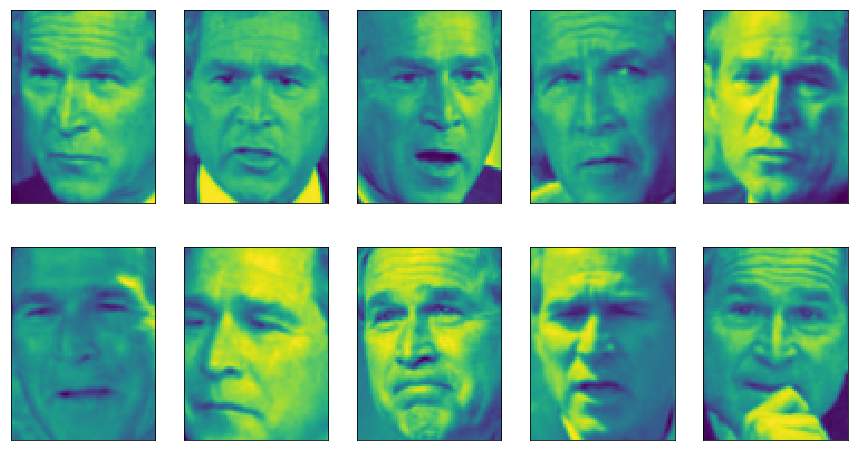

In [470]:
fix, axes = plt.subplots(2, 5, figsize=(15, 8),
subplot_kw={'xticks': (), 'yticks': ()})

tiger = lfw_people.images[lfw_people.target_names[lfw_people.target] == "George W Bush"]

for image, ax in zip(tiger, axes.ravel()):
    ax.imshow(image)

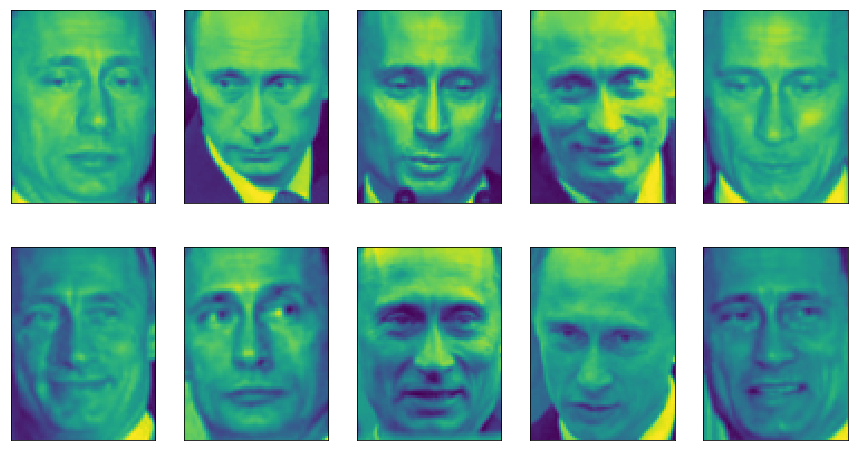

In [471]:
fix, axes = plt.subplots(2, 5, figsize=(15, 8),
subplot_kw={'xticks': (), 'yticks': ()})

tiger = lfw_people.images[lfw_people.target_names[lfw_people.target] == "Vladimir Putin"]

for image, ax in zip(tiger, axes.ravel()):
    ax.imshow(image)

#### Bush vs Tiger Woods

KMeans did a much better job with clustering pictures of Bush vs Tiger Woods. One interesting thing to not is that PCA does an excellent job of separating Bush and Woods along its first principal component. The second principal component appears to contain a lot less information that could be useful.

In [472]:
X_tiger = X['faces'][y['faces'] == names.index("Tiger Woods")]
y_tiger = y['faces'][y['faces'] == names.index("Tiger Woods")]

In [593]:
X_tiger_vs_bush = np.concatenate((X_tiger, X_bush), axis=0)
y_tiger_vs_bush = np.concatenate((y_tiger, y_bush), axis=0)

pca = PCA(n_components=15, random_state=DEFAULT_SEED)
X_tiger_vs_bush_pca = normalize(pca.fit_transform(X_tiger_vs_bush))

Text(0.5,1,'Tiger vs Bush')

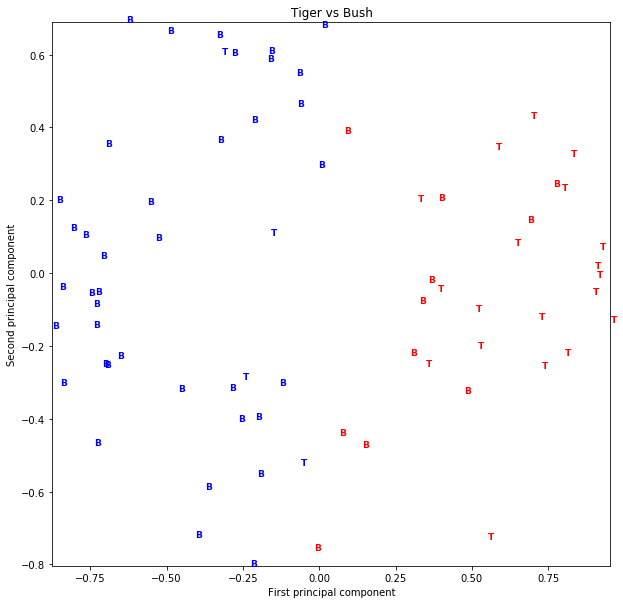

In [594]:
kmeans = KMeans(n_clusters=2, random_state=DEFAULT_SEED)

kmeans.fit(X_tiger_vs_bush_pca)

clusters['kmeans_tvb'] = kmeans.labels_

colors = ["red", "blue"]

plt.figure(figsize=(10, 10))
plt.xlim(X_tiger_vs_bush_pca[:, 0].min(), X_tiger_vs_bush_pca[:, 0].max())
plt.ylim(X_tiger_vs_bush_pca[:, 1].min(), X_tiger_vs_bush_pca[:, 1].max())

for i in range(len(X_tiger_vs_bush_pca)):
    if names[y_tiger_vs_bush[i]] == "George W Bush":
        tmp = "B"
    else:
        tmp = "T"
    
    plt.text(X_tiger_vs_bush_pca[i, 0], X_tiger_vs_bush_pca[i, 1], tmp,
             color = colors[kmeans.labels_[i]],
             fontdict={'weight': 'bold', 'size': 9})

plt.xlabel("First principal component")
plt.ylabel("Second principal component")
plt.title("Tiger vs Bush")

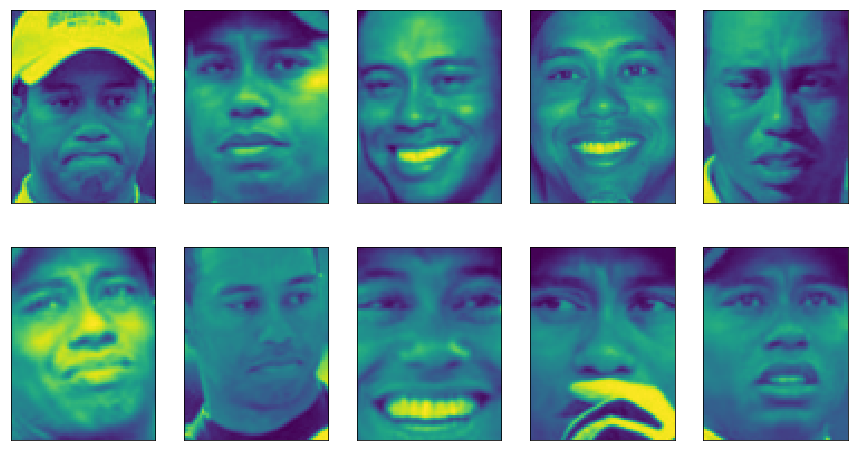

In [475]:
fix, axes = plt.subplots(2, 5, figsize=(15, 8),
subplot_kw={'xticks': (), 'yticks': ()})

tiger = lfw_people.images[lfw_people.target_names[lfw_people.target] == "Tiger Woods"]

pixel_intensity = []

for image, ax in zip(tiger, axes.ravel()):
    ax.imshow(image)
    tmp = np.average(image)

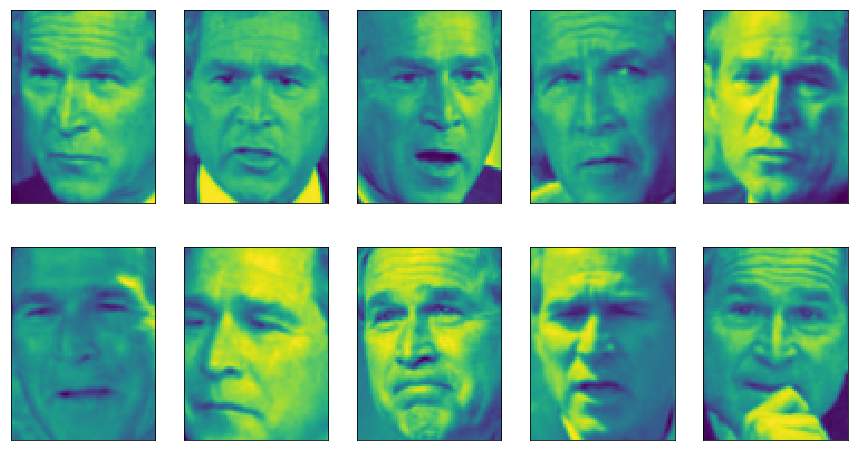

In [476]:
fix, axes = plt.subplots(2, 5, figsize=(15, 8),
subplot_kw={'xticks': (), 'yticks': ()})

tiger = lfw_people.images[lfw_people.target_names[lfw_people.target] == "George W Bush"]

for image, ax in zip(tiger, axes.ravel()):
    ax.imshow(image)

In [477]:
count = [{'Bush': 0,
          'Tiger': 0},
         {'Bush': 0,
          'Tiger': 0}]

for i, label in enumerate(kmeans.labels_):
    if names[y_tiger_vs_bush[i]] == "George W Bush" and label == 0:
        count[0]['Bush'] += 1
    elif names[y_tiger_vs_bush[i]] == "George W Bush" and label == 1:
        count[1]['Bush'] += 1
    elif label == 0:
        count[0]['Tiger'] += 1
    else:
        count[1]['Tiger'] += 1

In [478]:
print("Cluster A: ", count[0])
print("Cluster B: ", count[1])

Cluster A:  {'Bush': 10, 'Tiger': 19}
Cluster B:  {'Bush': 40, 'Tiger': 4}


In [479]:
X_putin = X['faces'][y['faces'] == names.index("Tiger Woods")]
y_putin = y['faces'][y['faces'] == names.index("Tiger Woods")]

X_bush = X['faces'][y['faces'] == names.index("George W Bush")]
y_bush = y['faces'][y['faces'] == names.index("George W Bush")]

print("Samples:")
print("Bush ", len(y_bush))
print("Tiger ", len(y_putin))

Samples:
Bush  50
Tiger  23


## DBSCAN

DBSCAN had some interesting results depending on how its hyperparameters were tuned. If "eps" were too low, then the algorithm would classify everything as noise. Conversely, increasing it too much would cause all the data to fit one cluster. In the testing done, a value of 1 seem to perform best. Its also intereting to note the precence of a third cluster defined by the algorithm. This is due to that data fitting the DBSCAN's conditions of having a core point and the minimum samples. In this case 3 of Bush's samples were clustered into their own set.

[-1  0  0  0  0 -1  0  0  0  0 -1  0 -1 -1  0  0  0  0  1  0  0 -1  0  1
  2  1  1  1  1 -1  1  1 -1  1  1 -1  1  1  1  1  1  1  1  0  1 -1  1  1
 -1  2  0  1  1  1 -1  2  1 -1 -1  1 -1  1 -1 -1  1  1 -1 -1  1  1  1  1
  0]


Text(0.5,1,'Tiger vs Bush')

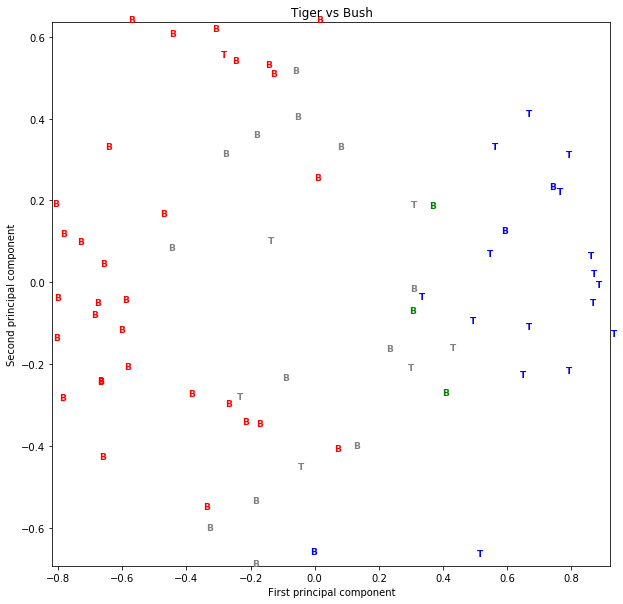

In [492]:
dbscan = DBSCAN(eps=1, min_samples=3)

dbscan.fit(X_tiger_vs_bush_pca)

print(dbscan.labels_)

clusters['dbscan_tvb'] = dbscan.labels_

colors = ["blue", "red", "green", "orange", "grey"]

plt.figure(figsize=(10, 10))
plt.xlim(X_tiger_vs_bush_pca[:, 0].min(), X_tiger_vs_bush_pca[:, 0].max())
plt.ylim(X_tiger_vs_bush_pca[:, 1].min(), X_tiger_vs_bush_pca[:, 1].max())

for i in range(len(X_tiger_vs_bush_pca)):
    if names[y_tiger_vs_bush[i]] == "George W Bush":
        tmp = "B"
    else:
        tmp = "T"
    
    plt.text(X_tiger_vs_bush_pca[i, 0], X_tiger_vs_bush_pca[i, 1], tmp,
             color = colors[dbscan.labels_[i]],
             fontdict={'weight': 'bold', 'size': 9})

plt.xlabel("First principal component")
plt.ylabel("Second principal component")
plt.title("Tiger vs Bush")

## Agglomerative Clustering

Agglomerative Clustering is very successful (compared to the other algorithms) in creating more homogeneous clusters. Unfortuantely there is some bleed over between the two clusters but as you can see, it does a good job when looking at the first two principal componenets when looking a the data from Tiger vs Bush. 

Text(0.5,1,'Tiger vs Bush')

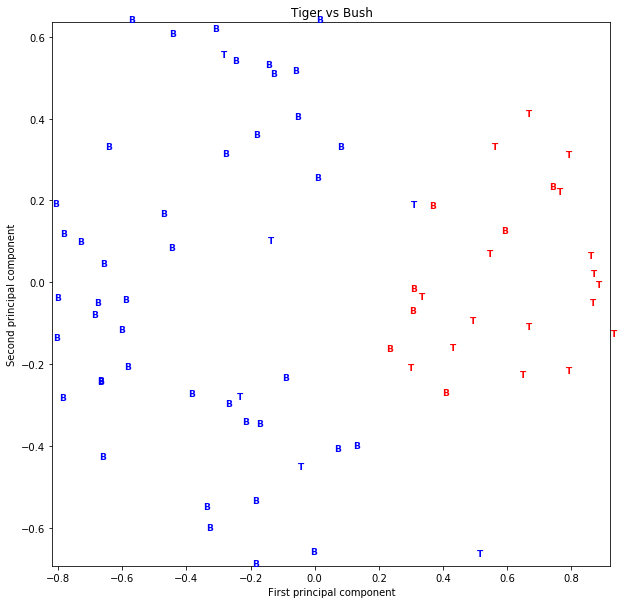

In [493]:
agglo = AgglomerativeClustering(n_clusters=2)

agglo.fit(X_tiger_vs_bush_pca)

clusters['agglo_tvb'] = agglo.labels_

colors = ["blue", "red", "grey"]

plt.figure(figsize=(10, 10))
plt.xlim(X_tiger_vs_bush_pca[:, 0].min(), X_tiger_vs_bush_pca[:, 0].max())
plt.ylim(X_tiger_vs_bush_pca[:, 1].min(), X_tiger_vs_bush_pca[:, 1].max())

for i in range(len(X_tiger_vs_bush_pca)):
    if names[y_tiger_vs_bush[i]] == "George W Bush":
        tmp = "B"
    else:
        tmp = "T"
    
    plt.text(X_tiger_vs_bush_pca[i, 0], X_tiger_vs_bush_pca[i, 1], tmp,
             color = colors[agglo.labels_[i]],
             fontdict={'weight': 'bold', 'size': 9})

plt.xlabel("First principal component")
plt.ylabel("Second principal component")
plt.title("Tiger vs Bush")

Like the other algorithms we've seen, agglomerative clustering doesn't perform well when trying to differentiate between Putin and Bush. A visual inspection of the first two components show that the spread between points is rather random so the use of any clustering algorithm on this data won't likely work well.

Text(0.5,1,'Bush vs Putin')

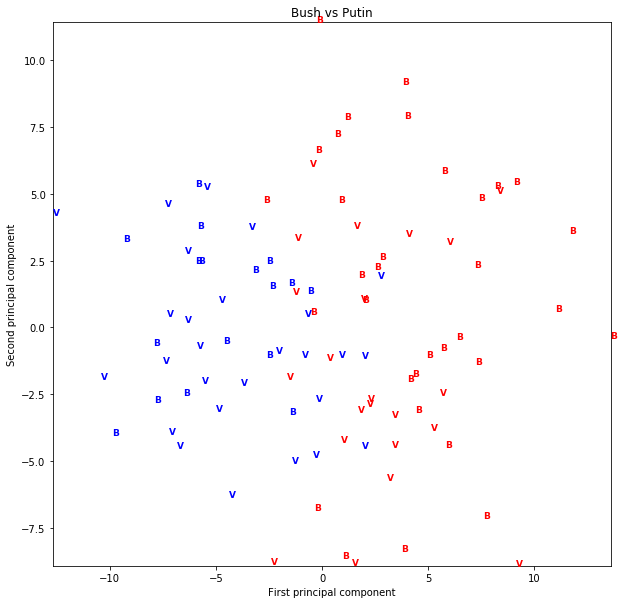

In [494]:
agglo = AgglomerativeClustering(n_clusters=2)

agglo.fit_predict(X_putin_vs_bush_pca)

clusters['agglo_pvb'] = agglo.labels_

colors = ["red", "blue"]

plt.figure(figsize=(10, 10))
plt.xlim(X_putin_vs_bush_pca[:, 0].min(), X_putin_vs_bush_pca[:, 0].max())
plt.ylim(X_putin_vs_bush_pca[:, 1].min(), X_putin_vs_bush_pca[:, 1].max())

for i in range(len(X_putin_vs_bush_pca)):
    if names[y_putin_vs_bush[i]] == "George W Bush":
        tmp = "B"
    else:
        tmp = "V"
    
    plt.text(X_putin_vs_bush_pca[i, 0], X_putin_vs_bush_pca[i, 1], tmp,
             color = colors[agglo.labels_[i]],
             fontdict={'weight': 'bold', 'size': 9})

plt.xlabel("First principal component")
plt.ylabel("Second principal component")
plt.title("Bush vs Putin")

In [495]:
count = [{'Bush': 0,
          'Putin': 0},
         {'Bush': 0,
          'Putin': 0}]

for i, label in enumerate(kmeans.labels_):
    if names[y_putin_vs_bush[i]] == "George W Bush" and label == 0:
        count[0]['Bush'] += 1
    elif names[y_putin_vs_bush[i]] == "George W Bush" and label == 1:
        count[1]['Bush'] += 1
    elif label == 0:
        count[0]['Putin'] += 1
    else:
        count[1]['Putin'] += 1

In [496]:
print("Cluster A: ", count[0])
print("Cluster B: ", count[1])

Cluster A:  {'Putin': 23, 'Bush': 6}
Cluster B:  {'Putin': 26, 'Bush': 18}


### Comparison

As a metric to compare all of the clustering algorithms from lab3, I've elected to use the adjusted random score. Since we have the ground truth I felt this would be the most effective metric to consider. The scoring works by taking the adjusted random index (tp + tn) / (tp + fp + fn + fp) and then subtracts the expected random index. This value is then divided by the maximum random index over the expected random index. This scoring metric is able to tell if a clustering is random ~0 or better than random (>0). From the opservations below, all algorithms performed near random when comparing Bush and Putin. All of the algorithms performed significantly better when considering comparisons between Tiger Woods and Bush with Agglo being the highest at 0.39.

In [497]:
print("KMeans")
print("Putin vs Bush: ", adjusted_rand_score(y_putin_vs_bush, clusters['kmeans_pvb']))
print("Tiger vs Bush: ", adjusted_rand_score(y_tiger_vs_bush, clusters['kmeans_tvb']))
print()
print("DBSCAN")
print("Tiger vs Bush: ", adjusted_rand_score(y_tiger_vs_bush, clusters['dbscan_tvb']))
print()
print("Agglo")
print("Putin vs Bush: ", adjusted_rand_score(y_putin_vs_bush, clusters['agglo_pvb']))
print("Tiger vs Bush: ", adjusted_rand_score(y_tiger_vs_bush, clusters['agglo_tvb']))


KMeans
Putin vs Bush:  -0.010195666841592238
Tiger vs Bush:  0.3691079329723244

DBSCAN
Tiger vs Bush:  0.3073738144119616

Agglo
Putin vs Bush:  0.03527256069628955
Tiger vs Bush:  0.3985084191919548


#### What about the whole Faces in the Wild set?

When evaluating the entire Faces dataset the algorithms all performed near random. Given the number of unique labels this is not hard to fathom.

In [503]:
# some of the code used copied from "Introduction to Machine Learning with Python"

algorithms = [KMeans(n_clusters=2), AgglomerativeClustering(n_clusters=2), DBSCAN()]

for algorithm in algorithms:
    y_pred_faces = algorithm.fit_predict(X_pca['faces'])
    print(str(algorithm.__class__.__name__), adjusted_rand_score(y_pred_faces, y['faces']))

KMeans 0.0030109057687800044
AgglomerativeClustering 0.0025588563537196343
DBSCAN 0.00011975150640259871


# Preprocessing

### Normalization

In [499]:
def normalize_dict(X_train, X_test):
    X_train_norm = {}
    X_test_norm = {}
    
    for key in X_train:
        normalizer = Normalizer()
        normalizer.fit(X_train[key])

        X_train_norm[key] = normalizer.transform(X_train[key])
        X_test_norm[key] = normalizer.transform(X_test[key])
        
    return X_train_norm, X_test_norm

X_train_norm, X_test_norm = normalize_dict(X_train, X_test)

##### What normalized data looks like for the energy dataset:

When the transformation of energy was graphed the results were pretty interesting. As you can see below, x3 and x5 both have a similar variance and mean when graphed. One thing that stands out (and could effect classification/regression algorithms is the fact that x5 is so far to the right.

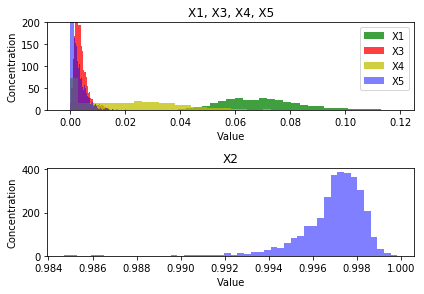

In [215]:
fig, (ax1, ax2) =  plt.subplots(2, 1)

ax1.hist(X_train_norm['energy'][:,0], 50, normed=1, facecolor='g', alpha=0.75)
ax1.hist(X_train_norm['energy'][:,2], 50, normed=1, facecolor='r', alpha=0.75)
ax1.hist(X_train_norm['energy'][:,3], 50, normed=1, facecolor='y', alpha=0.75)
ax1.hist(X_train_norm['energy'][:,4], 50, normed=1, facecolor='b', alpha=0.50)

ax1.set_title("X1, X3, X4, X5")
ax1.set_xlim(xmax=0.125)
ax1.set_ylim(ymax=200)
ax1.legend(['X1', 'X3', 'X4', 'X5'])

ax1.set_xlabel("Value")
ax1.set_ylabel("Concentration")

ax2.hist(X_train_norm['energy'][:,1], 50, normed=1, facecolor='b', alpha=0.50)
ax2.set_title("X2")

fig.tight_layout()

ax2.set_xlabel("Value")
ax2.set_ylabel("Concentration")

plt.show()

### Standardization

In [138]:
def standardize_dict(X_train, X_test):
    X_train_std = {}
    X_test_std = {}
    
    for key in X_train:
        standardizer = StandardScaler()
        standardizer.fit(X_train[key])

        X_train_std[key] = standardizer.transform(X_train[key])
        X_test_std[key] = standardizer.transform(X_test[key])
    
    return X_train_std, X_test_std

X_train_std, X_test_std = standardize_dict(X_train, X_test)

##### What standardized data looks like for the energy dataset:

Standardizations results were much more uniform. For all the features, the mean is locate a 0, however, the variance and the skew are still factors when comparing these features.

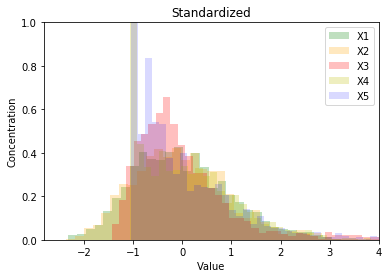

In [218]:
plt.hist(X_train_std['energy'][:,0], 50, normed=1, facecolor='g', alpha=0.25)
plt.hist(X_train_std['energy'][:,1], 50, normed=1, facecolor='orange', alpha=0.25)
plt.hist(X_train_std['energy'][:,2], 50, normed=1, facecolor='r', alpha=0.25)
plt.hist(X_train_std['energy'][:,3], 50, normed=1, facecolor='y', alpha=0.25)
plt.hist(X_train_std['energy'][:,4], 50, normed=1, facecolor='b', alpha=0.15)

plt.title("Standardized")
plt.xlim(xmax=4)
plt.ylim(ymax=1)
plt.xlabel('Value')
plt.ylabel('Concentration')
plt.legend(['X1', 'X2', 'X3', 'X4', 'X5'])

plt.show()

In [6]:
r_algorithms = {
    'knn': KNeighborsRegressor(weights='distance', algorithm='auto'),
    'tree': DecisionTreeRegressor(random_state=DEFAULT_SEED),
    'forest': RandomForestRegressor(random_state=DEFAULT_SEED),
    'svm': SVR(gamma='auto'),
    'mlp': MLPRegressor(early_stopping=True, random_state=DEFAULT_SEED)
}

c_algorithms = {
    'knn': KNeighborsClassifier(weights='distance', algorithm='auto'),
    'tree': DecisionTreeClassifier(random_state=DEFAULT_SEED),
    'forest': RandomForestClassifier(random_state=DEFAULT_SEED),
    'svm': SVC(gamma='auto'),
    'mlp': MLPClassifier(early_stopping=True, random_state=DEFAULT_SEED)
}

parameters = {
    'knn': {
        'n_neighbors': [1, 3, 5, 10, 15]
    },
    'tree': {
        'max_features': [None, 'sqrt'],
        'max_depth': [None, 1, 5, 10, 15]
    },
    'forest': {
        'n_estimators': [1, 5, 10, 15, 20],
        'max_depth': [None, 1, 5, 10, 15]
    },
    'svm': {
        'degree': [2, 3, 4]
    },
    'mlp': {
        'alpha': [0.001, 0.0001, 0.00001],
        'activation': ['logistic', 'relu']
    },
    'norm': {},
    'std': {},
    'pca': {
        'n_components': [1, 2, 3, 5, 50],
        'whiten': [True, False]
    },
    'nmf': {
        'n_components': [1, 2, 3, 5, 50]
    },
    'kmeans': {
        'n_clusters': [2, 5, 8, 50]
    }
}

preprocessors = {
    'norm': Normalizer(),
    'std': StandardScaler(),
    'pca': PCA(random_state=DEFAULT_SEED),
    'nmf': NMF(random_state=DEFAULT_SEED),
    'kmeans': KMeans(random_state=DEFAULT_SEED)
}

### Benchmark: No Preprocessing

These tests are establish a baseline for what the alogrithms could be expected to do without preprocessing. I'd also like to point out that I'm not using the MSE metric, and instead I have chosen to use the coefficient of determination R^2.

#### Regression

Note that SVM does very poorly without any preprocessing.

In [539]:
print("Energy Dataset (No Preprocessing)")
for key in r_algorithms:
    tmp = GridSearchCV(r_algorithms[key], parameters[key])
    tmp.fit(X_train['energy'], y_train['energy'].as_matrix().ravel())
    print(key + " : " + str(tmp.score(X_test['energy'], y_test['energy'].as_matrix().ravel())))

Energy Dataset (No Preprocessing)
knn : 0.5374595000808534
mlp : 0.7906219753399508
svm : 0.002939624714861755
forest : 0.8448063370139388
tree : 0.7587334965567072


#### Classification

Most of the algorithms perform fairly well on MNIST. None of the algorithms have good performance on Faces.

In [546]:
print("MNIST Dataset (No Preprocessing)")
for key in c_algorithms:
    tmp = c_algorithms[key]
    tmp.fit(X_train['mnist'], y_train['mnist'].as_matrix().ravel())
    print(key + " : " + str(tmp.score(X_test['mnist'], y_test['mnist'].as_matrix().ravel())))

MNIST Dataset (No Preprocessing)
knn : 0.95
mlp : 0.8885
svm : 0.118
forest : 0.9085
tree : 0.8015


In [548]:
print("Faces Dataset (No Preprocessing)")
for key in c_algorithms:
    tmp = c_algorithms[key]
    tmp.fit(X_train['faces'], y_train['faces'])
    print(key + " : " + str(tmp.score(X_test['faces'], y_test['faces'])))

Faces Dataset (No Preprocessing)
knn : 0.25549132947976877
mlp : 0.04971098265895954
svm : 0.12716763005780346
forest : 0.223121387283237
tree : 0.12947976878612716


### Normalized

Normalization actually decreases the accuracy / increases error on all of the data sets considered. MNIST was left out because it is already normalized.

#### Regression

In [557]:
print("Energy Dataset (Normalized)")
for key in r_algorithms:
    pipe = Pipeline([('pre', preprocessors['norm']), ('reg', r_algorithms[key])])
    parameter_grid = {}
    
    alg_params = parameters[key]
    
    for p in alg_params:
        parameter_grid['reg__'+p] = alg_params[p]
        
    
    tmp = GridSearchCV(pipe, param_grid=parameter_grid)
    tmp.fit(X_train['energy'], y_train['energy'].as_matrix().ravel())
    print(key + " : " + str(tmp.score(X_test['energy'], y_test['energy'].as_matrix().ravel())))

Energy Dataset (Normalized)
knn : 0.3794198418741469
mlp : 0.00340975550246414
svm : 0.018107753195014897
forest : 0.5467527256599267
tree : 0.49267580941494615


#### Classification

In [559]:
print("Faces Dataset (Normalized)")
for key in c_algorithms:
    pipe = Pipeline([('pre', preprocessors['norm']), ('reg', c_algorithms[key])])
    pipe.fit(X_train['faces'], y_train['faces'])
    print(key + " : " + str(pipe.score(X_test['faces'], y_test['faces'])))

Faces Dataset (Normalized)
knn : 0.3063583815028902
mlp : 0.12716763005780346
svm : 0.12716763005780346
forest : 0.21965317919075145
tree : 0.1283236994219653


### Standardize

Standardization boosted accuracy/decreased error on all of the datasets. One interesting thing to note is that MLP is near 50% accuracy on the faces dataset. All the other algorithms are better than random.

#### Regression

In [563]:
print("Energy Dataset (Normalized)")
for key in r_algorithms:
    pipe = Pipeline([('pre', preprocessors['norm']), ('reg', r_algorithms[key])])
    parameter_grid = {}
    
    alg_params = parameters[key]
    
    for p in alg_params:
        parameter_grid['reg__'+p] = alg_params[p]
        
    
    tmp = GridSearchCV(pipe, param_grid=parameter_grid)
    tmp.fit(X_train['energy'], y_train['energy'].as_matrix().ravel())
    print(key + " : " + str(tmp.score(X_test['energy'], y_test['energy'].as_matrix().ravel())))

Energy Dataset (Standardized)
knn : 0.8530379997499713
mlp : 0.8771537153142557
svm : 0.8698923851936273
forest : 0.8448063370139388
tree : 0.7587334965567072


#### Classification

In [565]:
print("MNIST Dataset (Standardized)")
for key in c_algorithms:
    pipe = Pipeline([('pre', preprocessors['std']), ('reg', c_algorithms[key])])
    pipe.fit(X_train['mnist'], y_train['mnist'])
    print(key + " : " + str(pipe.score(X_test['mnist'], y_test['mnist'])))

MNIST Dataset (Standardized)
knn : 0.919
mlp : 0.9355
svm : 0.9365
forest : 0.909
tree : 0.801


In [566]:
print("Faces Dataset (Standardized)")
for key in c_algorithms:
    pipe = Pipeline([('pre', preprocessors['std']), ('reg', c_algorithms[key])])
    pipe.fit(X_train['faces'], y_train['faces'])
    print(key + " : " + str(pipe.score(X_test['faces'], y_test['faces'])))

Faces Dataset (Standardized)
knn : 0.27630057803468205
mlp : 0.4820809248554913
svm : 0.33872832369942196
forest : 0.22196531791907514
tree : 0.12947976878612716


### PCA

PCA appeared to hurt the accuracy/error of the predictions on the energy dataset. As you can see below, the error gets worse when the number of components are decreased from 3 to 1. Accuracy on classifiers for the other datasets increases with knn seeing a 95% accuracy on MNIST.

#### Regression

In [574]:
print("Energy Dataset (PCA - 3 components)")
for key in r_algorithms:
    pipe = Pipeline([('pre', preprocessors['pca']), ('reg', r_algorithms[key])])
    parameter_grid = {}
    
    alg_params = parameters[key]
    pre_params = parameters['pca']
    
    for p in alg_params:
        parameter_grid['reg__'+p] = alg_params[p]
        
    parameter_grid['pre__n_components'] = [3]
    
    tmp = GridSearchCV(pipe, param_grid=parameter_grid)
    tmp.fit(X_train['energy'], y_train['energy'].as_matrix().ravel())
    print(key + " : " + str(tmp.score(X_test['energy'], y_test['energy'].as_matrix().ravel())))
  

Energy Dataset (PCA - 3 components)
knn : 0.4915508536043854
mlp : 0.46825737789193134
svm : 0.003799208838911605
forest : 0.5430497081425494
tree : 0.5155826984399505


In [576]:
print("Energy Dataset (PCA - 1 components)")
for key in r_algorithms:
    pipe = Pipeline([('pre', preprocessors['pca']), ('reg', r_algorithms[key])])
    parameter_grid = {}
    
    alg_params = parameters[key]
    pre_params = parameters['pca']
    
    for p in alg_params:
        parameter_grid['reg__'+p] = alg_params[p]
        
    parameter_grid['pre__n_components'] = [1]
    
    tmp = GridSearchCV(pipe, param_grid=parameter_grid)
    tmp.fit(X_train['energy'], y_train['energy'].as_matrix().ravel())
    print(key + " : " + str(tmp.score(X_test['energy'], y_test['energy'].as_matrix().ravel())))
  

Energy Dataset (PCA - 1 components)
knn : 0.3332543324397472
mlp : 0.43908904712045516
svm : 0.17886655540603946
forest : 0.4575924484956657
tree : 0.44428733259364095


#### Classification

In [579]:
print("MNIST Dataset (PCA - 20 components)")
for key in c_algorithms:
    pipe = Pipeline([('pre', preprocessors['pca']), ('clf', c_algorithms[key])])
    parameter_grid = {}
    
    alg_params = parameters[key]
    
    for p in alg_params:
        parameter_grid['clf__'+p] = alg_params[p]
        
    parameter_grid['pre__n_components'] = [20]
    
    tmp = GridSearchCV(pipe, param_grid=parameter_grid)
    tmp.fit(X_train['mnist'], y_train['mnist'].as_matrix().ravel())
    print(key + " : " + str(tmp.score(X_test['mnist'], y_test['mnist'].as_matrix().ravel())))

MNIST Dataset (PCA - 20 components)
knn : 0.956
mlp : 0.878
svm : 0.118
forest : 0.903
tree : 0.798


In [581]:
print("Faces Dataset (PCA - 20 components)")
for key in c_algorithms:
    pipe = Pipeline([('pre', preprocessors['pca']), ('clf', c_algorithms[key])])
    parameter_grid = {}
    
    alg_params = parameters[key]
    
    for p in alg_params:
        parameter_grid['clf__'+p] = alg_params[p]
        
    parameter_grid['pre__n_components'] = [20]
    
    tmp = GridSearchCV(pipe, param_grid=parameter_grid)
    tmp.fit(X_train['faces'], y_train['faces'])
    print(key + " : " + str(tmp.score(X_test['faces'], y_test['faces'])))

Faces Dataset (PCA - 20 components)
knn : 0.2161849710982659
mlp : 0.1976878612716763
svm : 0.12716763005780346
forest : 0.21271676300578035
tree : 0.14104046242774568


### NMF

#### Regression

In [584]:
print("Energy Dataset (NMF - 3 components)")
for key in r_algorithms:
    pipe = Pipeline([('pre', preprocessors['nmf']), ('reg', r_algorithms[key])])
    parameter_grid = {}
    
    alg_params = parameters[key]
    
    for p in alg_params:
        parameter_grid['reg__'+p] = alg_params[p]
        
    parameter_grid['pre__n_components'] = [3]
    if key == 'mlp':
        parameter_grid['reg__max_iter'] = [400]
    
    tmp = GridSearchCV(pipe, param_grid=parameter_grid)
    tmp.fit(X_train['energy'], y_train['energy'].as_matrix().ravel())
    print(key + " : " + str(tmp.score(X_test['energy'], y_test['energy'].as_matrix().ravel())))
  

Energy Dataset (PCA - 3 components)
knn : 0.5052668376474069
mlp : 0.4392829612522533
svm : 0.5236238654624822
forest : 0.5440395690268321
tree : 0.5079770500817742


#### Classification

In [587]:
print("MNIST Dataset (NMF - 10 components)")
for key in c_algorithms:
    pipe = Pipeline([('pre', preprocessors['nmf']), ('clf', c_algorithms[key])])
    parameter_grid = {}
    
    alg_params = parameters[key]
    
    for p in alg_params:
        parameter_grid['clf__'+p] = alg_params[p]
        
    parameter_grid['pre__n_components'] = [10]
    
    tmp = GridSearchCV(pipe, param_grid=parameter_grid)
    tmp.fit(X_train['mnist'], y_train['mnist'].as_matrix().ravel())
    print(key + " : " + str(tmp.score(X_test['mnist'], y_test['mnist'].as_matrix().ravel())))

MNIST Dataset (NMF - 10 components)
knn : 0.8465
mlp : 0.8215
svm : 0.8785
forest : 0.838
tree : 0.748


## Normalization with NMF

When data was nomalized before using NMF, regression on the energy dataset was much higher than with pure normalization. Given the fact that energy only has five features, any dimensionality reduction seemed to hurt its abilities.

In [10]:
print("Energy Dataset (Normalization then NMF)")
for key in r_algorithms:
    pipe = Pipeline([('pre', preprocessors['norm']), 
                     ('nmf', preprocessors['nmf']), 
                     ('reg', r_algorithms[key])])
    parameter_grid = {}
    
    alg_params = parameters[key]
    
    for p in alg_params:
        parameter_grid['reg__'+p] = alg_params[p]
        
    parameter_grid['nmf__n_components'] = [3]
    if key == 'mlp':
        parameter_grid['reg__max_iter'] = [400]
    
    tmp = GridSearchCV(pipe, param_grid=parameter_grid)
    tmp.fit(X_train['energy'], y_train['energy'].as_matrix().ravel())
    print(key + " : " + str(tmp.score(X_test['energy'], y_test['energy'].as_matrix().ravel())))
  

Energy Dataset (Normalization then NMF)
svm : 0.01061008007203501
knn : 0.02241389583493536
tree : 0.1135100060075086
mlp : 0.08055129848822107
forest : 0.15117746689505152


### Standardization with PCA

Standardizing the data before using PCA didn't have any measurable effect. Given the fact that MNIST was already normalized, this might explain why this happens.

In [11]:
print("MNIST Dataset (Standardization then PCA)")
for key in c_algorithms:
    pipe = Pipeline([('pre', preprocessors['std']), 
                     ('pca', preprocessors['pca']),
                     ('clf', c_algorithms[key])])
    parameter_grid = {}
    
    alg_params = parameters[key]
    
    for p in alg_params:
        parameter_grid['clf__'+p] = alg_params[p]
        
    parameter_grid['pca__n_components'] = [20]
    
    tmp = GridSearchCV(pipe, param_grid=parameter_grid)
    tmp.fit(X_train['mnist'], y_train['mnist'].as_matrix().ravel())
    print(key + " : " + str(tmp.score(X_test['mnist'], y_test['mnist'].as_matrix().ravel())))

MNIST Dataset (Standardization then PCA)
svm : 0.76
knn : 0.933
tree : 0.77
mlp : 0.929
forest : 0.9035


### Utilities

In [79]:
def train_best_model(X_train, y_train, algorithms, parameters):
    models = {} 
    for key in algorithms:
        models[key] = GridSearchCV(algorithms[key], parameters[key])
        models[key].fit(X_train, y_train)   
    return models

def predictions(X_test, models):
    y_pred = {}
    for key in models:
        y_pred = models.predict(X_test)
    return y_pred